In [0]:
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

#It is also of critical importance to ensure that one is using a GPU to handle the computational load of the model.
#In my case, I am using a local GPU; therefore, its presence is noted below.
#If a GPU is not listed using the commands provided below, your CPU will attempt to handle the load associated with the CNN.
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 29482849431234554614
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6701764613
locality {
  bus_id: 1
  links {
  }
}
incarnation: 819358234544545
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [0]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('path/to/stage_1_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [0]:
pneumonia_locations

{'00436515-870c-4b36-a041-de91049b9ab4': [[264, 152, 213, 379],
  [562, 152, 256, 453]],
 '00704310-78a8-4b38-8475-49f4573b2dbb': [[323, 577, 160, 104],
  [695, 575, 162, 137]],
 '00aecb01-a116-45a2-956c-08d2fa55433f': [[288, 322, 94, 135],
  [547, 299, 119, 165]],
 '389628be-67a0-4854-a44e-0c4e2df93b04': [[696, 139, 250, 538],
  [262, 101, 253, 452]],
 ...}

In [0]:
# load and shuffle filenames
folder = 'path/to/sample_train/'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
#Roughly 80:20 split
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n training samples', len(train_filenames))
print('n validation samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n training samples 23124
n validation samples 2560


# CNN Model

In [0]:
#Defining a generator allows the model to arrange processes without loading everything into memory at once.
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in pneumonia_locations:
            # loop through pneumonia
            for location in pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='symmetric')
        msk = resize(msk, (self.image_size, self.image_size), mode='symmetric') > 0.5
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='symmetric')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [0]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
model = create_network(input_size=128, channels=16, n_blocks=2, depth=3)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 20
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# create train and validation generators
folder = 'path/to/sample_train/'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=16, image_size=128, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=16, image_size=128, shuffle=False, predict=False)

history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=20, shuffle=True)

Epoch 1/20
1445/1445 [==============================] - 1420s 983ms/step - loss: 0.4662 - acc: 0.9650 - mean_iou: 0.6369 - val_loss: 0.4504 - val_acc: 0.9599 - val_mean_iou: 0.6055
Epoch 2/20
1445/1445 [==============================] - 1448s 1s/step - loss: 0.4375 - acc: 0.9683 - mean_iou: 0.6766 - val_loss: 0.4366 - val_acc: 0.9728 - val_mean_iou: 0.7088
Epoch 3/20
1445/1445 [==============================] - 1403s 971ms/step - loss: 0.4248 - acc: 0.9696 - mean_iou: 0.6921 - val_loss: 0.4615 - val_acc: 0.9750 - val_mean_iou: 0.7459
Epoch 4/20
1445/1445 [==============================] - 1463s 1s/step - loss: 0.4166 - acc: 0.9705 - mean_iou: 0.7011 - val_loss: 0.4192 - val_acc: 0.9711 - val_mean_iou: 0.6920
Epoch 5/20
1445/1445 [==============================] - 1479s 1s/step - loss: 0.4117 - acc: 0.9710 - mean_iou: 0.7058 - val_loss: 0.4124 - val_acc: 0.9716 - val_mean_iou: 0.7026
Epoch 6/20
1445/1445 [==============================] - 1423s 985ms/step - loss: 0.4091 - acc: 0.9715 - 

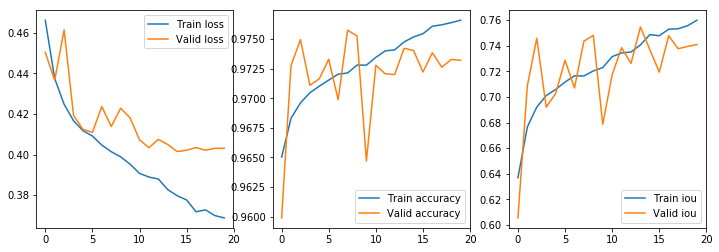

In [0]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

In [0]:
# load filenames
folder = 'path/to/sample_test/'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=16, image_size=128, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('path/to/sub3_1.csv')

n test samples: 1000
